
In this section we will train on a dataset that comprises of about 200,000 news headlines from HuffPost from 2012 to 2018 on 3 machine learning algorithms namely Naive Bayes, Ridge classifier, Xgboost. We have more than 40 different types of news in total.

(A) To begin, we first need to import all the necessary libraries to work.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from spacy.cli.download import download
import spacy
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import sklearn
import time
import re
import pickle
from string import punctuation
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
#from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

(B) Since information comes from different sources and it may contain words which are not useful to help the model learn better such as stopwords, html tags etc. So, we need to clean our data so that it is free from such redundant words as such noise and unnecessary features result in decreasing the overall performance of the model. We have performed the standard techniques and methods for pre-processing or cleaning text documents.

Tokenization - Tokenization is the process of dividing a piece of text into a stream of text or smaller units which we call tokens. Tokens can be characters, words, subwords, symbols or any other meaningful element. We need to perform tokenization when we are working with text data. These tokens obtained from tokenization are used for constructing the vocabulary which refers to the set of unique tokens present in the corpus.


Stopwords - Stopwords refers to those words which are used commonly in a language but they do not add much meaning to the sentence. Stopwords are words like a, the, to, at etc. We can safely ignore these words and keep our corpus free from unwanted words without sacrificing the meaning of the sentence. Also by removing stopwords size of our dataset decreases and this results in decreased time for training the model. It also helps to improve the performance of the model and increasing the classification accuracy. We have used the Spacy library for removing the stopwords.


Noise removal - There are other characters like punctuation's, special characters, multiple spaces, html tags etc which can be present in the text document and they are not required for text classification purpose. So we have removed multiple spaces, single characters, punctuation's , html tags from our data and finally lowered the data.


Lemmitization - There are standard two approaches used to analyze the meaning behind a word namely stemming and lemmatization. The process of converting a word to its base form is termed as lemmitization. Lemmitization takes the context of the word into consideration and convert it into its meaningful base form. On the other hand, stemming simply removes the last few characters of the word which often leads to spelling errors or incorrect meanings. So we have performed lemmitization on our data with the help of Spacy lemmatization. Spacy itself identifies the part-of-speech tag for the word and then assign a corresponding lemma to it.

In [ ]:
# downloading from nltk to help remove stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')
download(model="en_core_web_sm")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
def lem(sen):
    
    # Create a Doc object
    doc = nlp(sen)
  
    # Create list of tokens from given string
    tokens = []
    for token in doc:
        tokens.append(token)
  
    print(tokens)
  
    lemmatized_sentence = " ".join([token.lemma_ for token in doc])
  
    return(lemmatized_sentence)

In [ ]:
# pre processing

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\']',' ',text)
    text = text.split()
    text = [word for word in text if word not in stopw]
    text = ' '.join(text)
    text = re.sub(r'  ', ' ', text) 
    text = re.sub(r'   ', ' ', text)
    return text

# common preprocessing 
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    #lemmatization
    sentence=lem(sentence)

    #returns sentences in lower format
    return sentence.lower()

import re
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)



(C) Our dataset is stored in the google drive so we will mount our drive to the colab to access files from there smoothly and will load the dataset into a dataframe.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = "/gdrive/My Drive/Colab Notebooks/News_Category_Dataset_v2"

In [ ]:
# Importing the dataset
df = pd.read_json('/content/gdrive/MyDrive/Colab Notebooks/News_Category_Dataset_v2.json', lines='True') 
df.columns #Index(['authors', 'category', 'date', 'headline', 'link', 'short_description'], dtype='object')
df.shape  #(124989, 6)

(200853, 6)

(D) In our dataset there are many news categories which are very close to each other in meaning. For example, we have "Arts and Culture" and "Arts" as two separate categories which is not required as they both contain the same type of context. Another example are the categories "College" and "Education". So the first step is to reduce the number of categories by combining the ones very close to each other under one single roof for which we are using a groupper method inspired from LSTM classification by Derin which will receive the categories to group and the new name for the combined category as input.

In [ ]:
categories = df['category'].value_counts().index

def groupper(grouplist,name):
    for ele in categories:
        if ele in grouplist:
            df.loc[df['category'] == ele, 'category'] = name

In [ ]:
groupper( grouplist= ['BUSINESS' ,  'MONEY'] , name =  'FINANCE')

groupper( grouplist= ['THE WORLDPOST' , 'WORLDPOST' , 'WORLD NEWS'] , name =  'WORLDNEWS')

groupper( grouplist= ['ENVIRONMENT' ,'GREEN'] , name =  'ENVIRONMENT')

groupper( grouplist= ['TECH', 'SCIENCE'] , name =  'TECHNOLOGY')

groupper( grouplist= ['WELLNESS', 'HEALTHY LIVING'] , name =  'HEALTH')

groupper( grouplist= [ 'PARENTING', 'PARENTS'] , name =  'PARENTING')

groupper( grouplist= [ 'EDUCATION' ,'COLLEGE'] , name =  'EDUCATION')

groupper( grouplist= ['FOOD & DRINK', 'TASTE'] , name =  'FOOD')

groupper( grouplist= ['STYLE & BEAUTY' ,'STYLE'] , name =  'STYLE')

groupper( grouplist= ['ARTS & CULTURE','CULTURE & ARTS','ARTS'] , name =  'ART-CULTURE')

groupper( grouplist= ['WOMEN','QUEER VOICES', 'LATINO VOICES', 'BLACK VOICES'] , name =  'EMPOWERED VOICES')

groupper( grouplist= ['HOME & LIVING','TRAVEL'] , name =  'TRAVEL AND LIVING')

groupper( grouplist= ['WEDDINGS', 'DIVORCE'] , name =  'MARRIAGE')

groupper( grouplist= ['SPORTS','ENTERTAINMENT' , 'COMEDY','WEIRD NEWS'] , name =  'SPORTS AND ENTERTAINMENT')

groupper( grouplist= ['FIFTY' , 'IMPACT' ,'GOOD NEWS','MEDIA'] , name =  'GENERAL')

groupper( grouplist= ['CRIME',  'RELIGION'] , name =  'CRIME AND RELIGION')

In [ ]:
df.drop_duplicates(keep='last', inplace=True) 

In [ ]:
df.drop_duplicates(subset=['short_description','headline'],keep='last',inplace=True)

(E) As seen in the exploratory data analysis ipynb file that we are dealing with an imbalanced dataset since the four most well represented categories "Politics", "Sports and Entertainment", "Health" and "Empowered Voices" make up 50 percent of all the data samples. So we need to balance our dataset so as to not result in bias decisions. In order to have dataset balanced we are taking equal number of rows for every category. Then we will use a single integer for representing a class or category to be fed to the model.

In [ ]:
# since we have imbalanced dataset, so one way is we can take sab categories mei se equal number of rows making it balanced.
# container for dfs
dfs = []

# loop through each category and get 1004 rows and append to dfs
for category in df['category'].unique():
    temp = df[df['category']==category]
    dfs.append(temp.sample(2140)) #2140 is the minimum number available for each category
    
# concatenate dataframes
df = pd.concat(dfs)

# shuffle dataframe
df = df.sample(frac=1).reset_index(drop=True)

# first few rows
df.head()

,category,headline,authors,link,short_description,date
0,TRAVEL AND LIVING,10 Foods Around The World To Try Before You Di...,"Viator, Contributor\nTours and activities arou...",https://www.huffingtonpost.com/entry/10-foods-...,"Food and travel go hand in hand, and there's n...",2012-07-05
1,ART-CULTURE,"The Week In Art: Frieze Art Fair, 'The Scream'...",,https://www.huffingtonpost.com/entry/the-week-...,While not the most comforting aspect of the ex...,2012-05-06
2,EMPOWERED VOICES,"Gender Confirmation Surgeries Are Rising, And ...",Nina Golgowski,https://www.huffingtonpost.com/entry/gender-co...,There was nearly a fourfold increase from 2000...,2018-02-28
3,MARRIAGE,How to Handle the Inevitable Online Dating Dri...,"Angela Lutin, Contributor\nLifestyle Blogger a...",https://www.huffingtonpost.com/entry/how-to-ha...,I recently began online dating again. Dating a...,2013-05-22
4,FOOD,10 Healthy Whole Wheat Pasta Dishes,"Lauren Figeroa, Contributor\nThe Talking Kitchen",https://www.huffingtonpost.com/entry/healthy-w...,Transitioning to a healthier lifestyle can be ...,2012-09-19


In [ ]:
#Finally we are left with 17 categories having equal number of rows.
print("We have a total of {} categories".format(df['category'].nunique()))
df['category'].value_counts()

We have a total of 17 categories


TECHNOLOGY                  2140
SPORTS AND ENTERTAINMENT    2140
GENERAL                     2140
EDUCATION                   2140
MARRIAGE                    2140
CRIME AND RELIGION          2140
EMPOWERED VOICES            2140
FOOD                        2140
FINANCE                     2140
POLITICS                    2140
STYLE                       2140
ENVIRONMENT                 2140
TRAVEL AND LIVING           2140
WORLDNEWS                   2140
PARENTING                   2140
ART-CULTURE                 2140
HEALTH                      2140
Name: category, dtype: int64

(F) Cleaning the data by using the pre-processing functions.

In [ ]:
#The following code will clean our data by calling the functions created earlier for preprocessing.
reviews = []
sentences = list(df['headline'])
for sen in sentences:
    reviews.append(preprocess_text(clean_text(sen)))
    
reviews1 = []
sentences = list(df['short_description'])
for sen in sentences:
    reviews1.append(preprocess_text(clean_text(sen)))

Streaming output truncated to the last 5000 lines.
[It, difficult, divorce, take, things, personally, After, two, partnership, team, partner, recast, adversary]
[Become, More, Flexible, Sometimes, things, go, according, plan, traveling, Maybe, flight, cancelled, rains]
[No, men, women, bathrooms, slogan, opponents, civil, rights, protections]
[Jennifer, husband, Jeff, tied, knot, They, spent, last, five, years, traveling, around, world]
[Come, join, us]
[Regardless, whether, old, haunted, houses, young, enough, still, terrified, bowls, blood, ketchup, Halloween, time, parties, costumes, otherwise]
[How, Parent, Equally, When, One, Your, Children, Has, Disability, originally, appeared, Babble, com, reprinted]
[For, many, years, anticipating, start, revolution, satellite, market, majority, satellites, built, launched, would, micro, nano, pico, femto, variety]
[About, percent, Americans, trust, Trump]
[The, two, faced, foreign, policy, health, care, wages, Social, Security]
[Mexicans, rec

In [ ]:
# storing the pre-processed messages back into the dataframe
df['headline']=reviews
df['short_description']=reviews1

In [ ]:
# saving the pre-processed data into drive so we can use it later and will not have to spend time again in pre-processing
#df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/preprocessed_data.csv') 


In [ ]:
# concatinating the two columns headline and short_description into one so as to provide input to our model. This is a standard technique.
df['desc'] = df['headline'].astype(str)+"-"+df['short_description']
df.drop(columns =['headline','short_description'],axis = 1, inplace=True)
df.astype(str)
df.head()

,Unnamed: 0,category,authors,link,date,desc
0,0,TRAVEL AND LIVING,"Viator, Contributor\nTours and activities arou...",https://www.huffingtonpost.com/entry/10-foods-...,2012-07-05,food around the world to try before -pron- die...
1,1,ART-CULTURE,NaN,https://www.huffingtonpost.com/entry/the-week-...,2012-05-06,the week in art frieze art fair the scream big...
2,2,EMPOWERED VOICES,Nina Golgowski,https://www.huffingtonpost.com/entry/gender-co...,2018-02-28,gender confirmation surgery be rise and so be ...
3,3,MARRIAGE,"Angela Lutin, Contributor\nLifestyle Blogger a...",https://www.huffingtonpost.com/entry/how-to-ha...,2013-05-22,how handle inevitable online dating drive by--...
4,4,FOOD,"Lauren Figeroa, Contributor\nThe Talking Kitchen",https://www.huffingtonpost.com/entry/healthy-w...,2012-09-19,healthy whole wheat pasta dish-transition heal...


In [ ]:
df.drop(['authors', 'link', 'date'], axis = 1, inplace = True)  #dropping unnecessary rows

In [ ]:
# to shuffle the rows in dataframe so that training and learning is better
df.sample(frac=1)

,Unnamed: 0,category,desc
35462,35462,SPORTS AND ENTERTAINMENT,michael keaton reveal why -pron- walk away fro...
13086,13086,HEALTH,restless try rest-some call meditation other c...
2017,2017,HEALTH,home health aides the dementia care balance ac...
28800,28800,GENERAL,NaN
19490,19490,TECHNOLOGY,reddit be try something new making profit-edit...
...,...,...,...
26802,26802,CRIME AND RELIGION,papal tribunals-can pope francis thousand cath...
25368,25368,TECHNOLOGY,surprising ways music affect benefit -pron- br...
4246,4246,TRAVEL AND LIVING,a guide for first time solo travelers-don wait...
5642,5642,TRAVEL AND LIVING,escape from notting hill london staycation adv...


(G) Splitting the dataset in the standard ratio and fitting the model on our training data and finally making predictions for the test data.

For the purpose of feature selection we are using Scikit-learn’s CountVectorizer. It converts a collection of text documents into a vector of token counts and also permits text pre-processing in order to generate vactor representation which makes it a highly flexible in terms of feature representation. As a result we get a matrix of word counts irrespective of their order often refered as Document Term Matrix(DTM) or Bag of Words (BoW) on which we can apply the TfidfTransformer. Term Frequency — Inverse Document Frequency (TF-IDF) tells about the importance of a word in a document while also considering its relation to other documents in the same corpus. So, we have used Scikit-learn’s CountVectorizer to obtain the term frequency and then using the Scikit-learn’s TfidfTransformer we perform the IDF part. So using CountVectorizer and TfidfTransformer we have performed the feature selection.

In [ ]:
X,Y = df['desc'],df['category']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

**RidgeClassifier**

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RidgeClassifier()),
                     ])

text_clf.fit(X_train, y_train)


predicted = text_clf.predict(X_test)

print(sklearn.metrics.classification_report(y_test, predicted))

                          precision    recall  f1-score   support

             ART-CULTURE       0.66      0.64      0.65       523
      CRIME AND RELIGION       0.66      0.67      0.66       535
               EDUCATION       0.75      0.72      0.74       577
        EMPOWERED VOICES       0.59      0.43      0.50       535
             ENVIRONMENT       0.63      0.70      0.66       496
                 FINANCE       0.56      0.55      0.56       516
                    FOOD       0.76      0.84      0.80       550
                 GENERAL       0.45      0.27      0.34       555
                  HEALTH       0.57      0.64      0.60       535
                MARRIAGE       0.80      0.83      0.81       517
               PARENTING       0.57      0.68      0.62       537
                POLITICS       0.62      0.68      0.65       552
SPORTS AND ENTERTAINMENT       0.51      0.46      0.49       497
                   STYLE       0.74      0.76      0.75       557
         

In [ ]:
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)



In [ ]:
map_label = dict(enumerate(df.category.factorize()[1]))

In [ ]:
cnf_matrix = confusion_matrix(y_test,predicted)

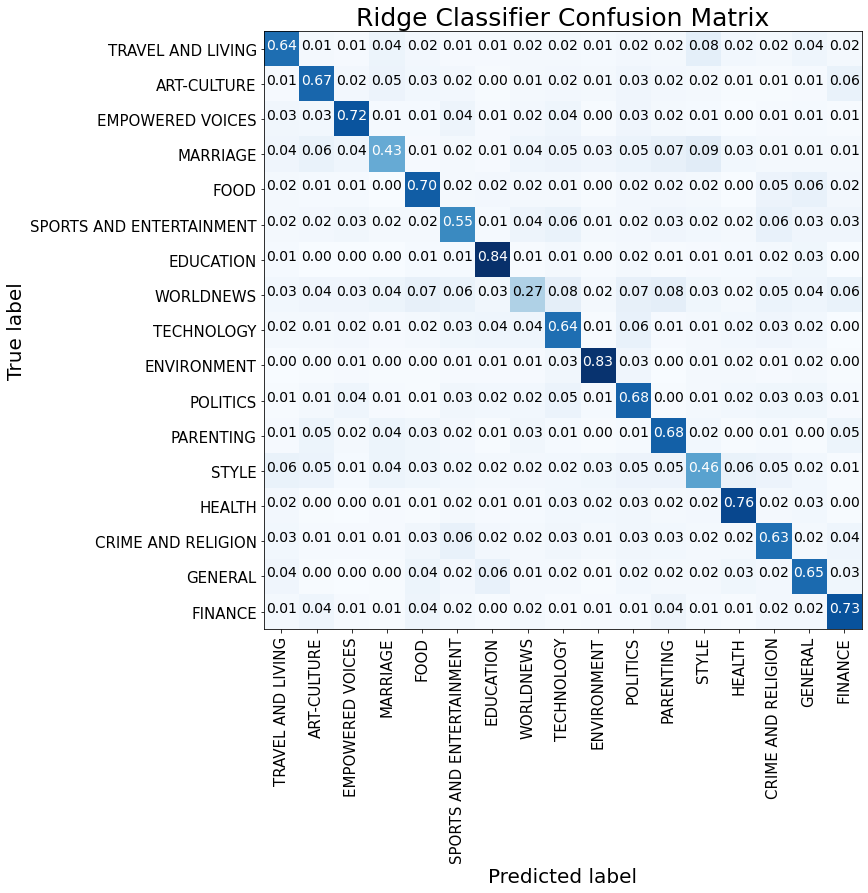

In [ ]:
plt.figure(figsize=(11,11))
plot_confusion_matrix(cnf_matrix, classes=list(map_label.values()),title="Ridge Classifier Confusion Matrix")
plt.show()

**Naive Bayes**

In [ ]:
text_clf_1 = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                     ])

text_clf_1.fit(X_train, y_train)


predicted = text_clf_1.predict(X_test)

print(sklearn.metrics.classification_report(y_test, predicted))

                          precision    recall  f1-score   support

             ART-CULTURE       0.72      0.52      0.61       523
      CRIME AND RELIGION       0.66      0.64      0.65       535
               EDUCATION       0.71      0.70      0.71       577
        EMPOWERED VOICES       0.58      0.44      0.50       535
             ENVIRONMENT       0.63      0.68      0.65       496
                 FINANCE       0.56      0.58      0.57       516
                    FOOD       0.79      0.79      0.79       550
                 GENERAL       0.49      0.24      0.32       555
                  HEALTH       0.53      0.69      0.60       535
                MARRIAGE       0.65      0.86      0.74       517
               PARENTING       0.46      0.76      0.58       537
                POLITICS       0.58      0.73      0.65       552
SPORTS AND ENTERTAINMENT       0.56      0.40      0.46       497
                   STYLE       0.75      0.75      0.75       557
         

In [ ]:
cnf_matrix = confusion_matrix(y_test,predicted)

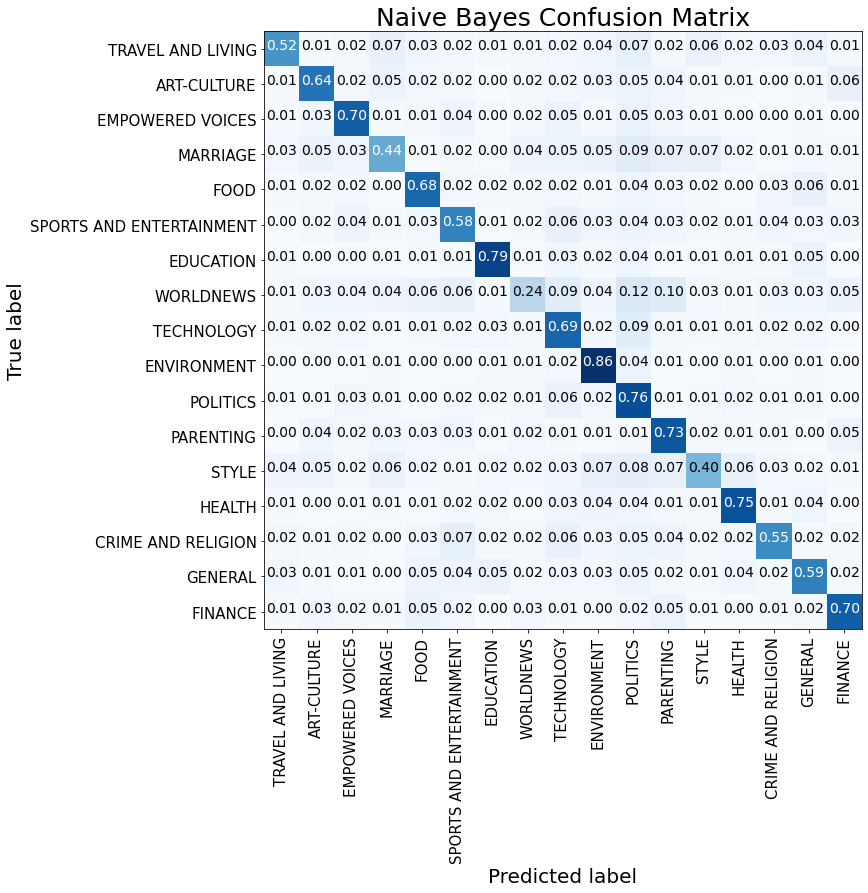

In [ ]:
plt.figure(figsize=(11,11))
plot_confusion_matrix(cnf_matrix, classes=list(map_label.values()),title="Naive Bayes Confusion Matrix")
plt.show()

**XGBoost classifier**

In [ ]:
from xgboost import XGBClassifier
text_clf_2 = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', XGBClassifier(objective= 'multi:softprob')),
                     ])

text_clf_2.fit(X_train, y_train)


predicted = text_clf_2.predict(X_test)

print(sklearn.metrics.classification_report(y_test, predicted))

                          precision    recall  f1-score   support

             ART-CULTURE       0.65      0.49      0.56       523
      CRIME AND RELIGION       0.62      0.56      0.59       535
               EDUCATION       0.71      0.66      0.69       577
        EMPOWERED VOICES       0.53      0.41      0.46       535
             ENVIRONMENT       0.55      0.53      0.54       496
                 FINANCE       0.49      0.46      0.47       516
                    FOOD       0.73      0.69      0.71       550
                 GENERAL       0.23      0.26      0.24       555
                  HEALTH       0.48      0.53      0.50       535
                MARRIAGE       0.83      0.78      0.81       517
               PARENTING       0.53      0.65      0.58       537
                POLITICS       0.54      0.62      0.58       552
SPORTS AND ENTERTAINMENT       0.29      0.41      0.34       497
                   STYLE       0.71      0.65      0.68       557
         

In [ ]:
cnf_matrix = confusion_matrix(y_test,predicted)

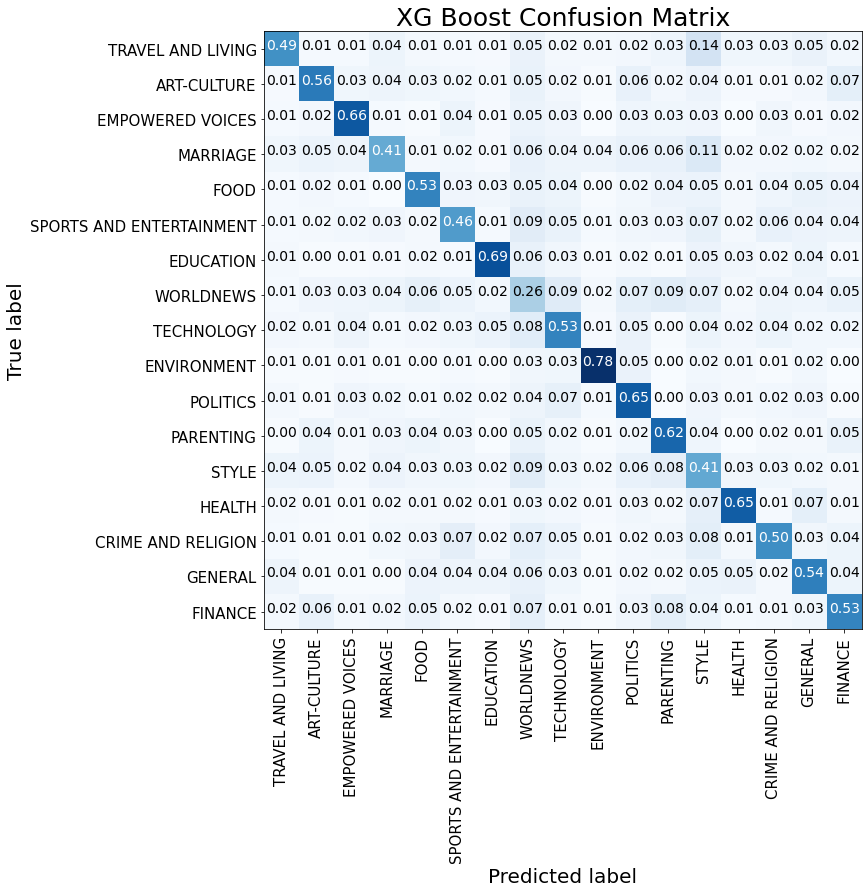

In [ ]:
plt.figure(figsize=(11,11))
plot_confusion_matrix(cnf_matrix, classes=list(map_label.values()),title="XG Boost Confusion Matrix")
plt.show()

(H) Conclusion - We have obtained accuracy of 64 percent using Ridge classifier algorithm with the maximum score obtained for the 'education' and 'environment' categories as 0.84 and 0.83 respectively and minimum score was obtained for the world news category as just 0.27 which is very poor. Similar observations were noted for Naive Bayes classifier which gave an accuracy of 63 percent with the maximum scores for 'education' and 'environment' categories as 0.79 and 0.86 respectively. Coming to the XGBoost classifier, its performance was poor compared to the other two machine learning algorithms with 55 percent accuracy and similar maximum and minimum score categories obtained. All these three machine learning algorithms are able to predict news related to education and environment precisely. This can be because of the distinct keywords present in these categories which do not fall in other categories like 'politics', 'finance' etc so because of which model is able to learn features for these categories properly. On the other hand, for the 'world news' category they are giving minimum scores. In many cases for the 'world news' category, the classifier gets confused with other categories like Finance, Crime and Religion, Technology, Style.This could be due to the presence of such keywords which are common to both the world news category and other categories like Technology, Finance etc.